In [1]:
# Standard
import pandas as pd
import numpy as np
import os
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
# Datapath and Setup
os.chdir("..")
PATH = os.getcwd()+os.sep
RANDOM_SEED = 142
K_FOLDS = 5


In [2]:
# Helper functions for structured data
# Get info about the dataset
def dataset_info(dataset, dataset_name: str):
    print(f"Dataset Name: {dataset_name} \
        | Number of Samples: {dataset.shape[0]} \
        | Number of Columns: {dataset.shape[1]}")
    print(30*"=")
    print("Column             Data Type")
    print(dataset.dtypes)
    print(30*"=")
    missing_data = dataset.isnull().sum()
    if sum(missing_data) > 0:
        print(missing_data[missing_data.values > 0])
    else:
        print("No Missing Data on this Dataset!")
    print(30*"=")
    print("Memory Usage: {} MB".\
         format(np.round(
         dataset.memory_usage(index=True).sum() / 10e5, 3
         )))
# Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   
# Bar Plot
def bar_plot(data, plot_title: str, x_axis: str, y_axis: str):
    colors = ["#0080ff",] * len(data)
    colors[0] = "#ff8000"
    trace = go.Bar(y=data.values, x=data.index, text=data.values, 
                    marker_color=colors)
    layout = go.Layout(autosize=False, height=600,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    xaxis={"title" : x_axis},
                    yaxis={"title" : y_axis},)
    fig = go.Figure(data=trace, layout=layout)
    fig.update_layout(template="simple_white")
    fig.update_traces(textposition="outside",
                    textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))                
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Plot Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)            
    iplot(fig)
# Histogram
def histogram_plot(data, plot_title: str, y_axis: str):
    trace = go.Histogram(x=data)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    yaxis={"title" : y_axis})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_layout(template="simple_white")
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Particular case: Histogram subplot (1, 2)
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
                        feature_b: str, title: str, title_a: str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
                        title_a,
                        title_b
                        )
                    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a],
                               showlegend=False),
                                row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b],
                               showlegend=False),
                              row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
                        title={"text" : title,
                        "y" : 0.9,
                        "x" : 0.5,
                        "xanchor" : "center",
                        "yanchor" : "top"},  
                        yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.Churn.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"], predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"], predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"], predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"], predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"], predict_unseen["Label"])

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["Label"],
                         predict_unseen["Label"],
                         labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

2. Load Data

In [3]:
import pandas as pd

dataset = pd.read_csv(r"C:\Users\Sona\Desktop\Eai churn prediction\Dataset.csv")
dataset.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
dataset[dataset.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [5]:
dataset_info(dataset, "customers")

Dataset Name: customers         | Number of Samples: 7043         | Number of Columns: 21
Column             Data Type
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
No Missing Data on this Dataset!
Memory Usage: 1.183 MB


In [6]:
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
print(f"The Feature TotalCharges is type {dataset.TotalCharges.dtype} now!")

The Feature TotalCharges is type float64 now!


3. Exploratory Data Analysis

In [7]:
pie_plot(dataset["Churn"].value_counts(), 
         plot_title="<b>Client Churn Distribution<b>")

In [8]:
# Analysis of the Contract Type
df_aux = dataset.query('Churn == "No"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of not Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

In [9]:
df_aux = dataset.query('Churn == "Yes"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

In [10]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "No")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for not Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

In [11]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "Yes")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")


In [12]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["PaymentMethod"].value_counts()
bar_plot(df_aux, "<b>Payment Method of Month-to-month contract Churned Clients</b>",
         "<i>Payment Method</i>", "<i>Count</i>")

In [13]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["tenure"].value_counts().head(5)
bar_plot(df_aux, "<b>Tenure of Month-to-month contract for Churned Clients</b>",
         "<i>Tenure</i>", "<i>Count</i>")


In [14]:
#Setting up PyCaret

data, data_unseen = data_sampling(dataset, 0.9, RANDOM_SEED)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 704 samples for Unseen Data.


In [15]:
exp01 = setup(
    data=data,
    target="Churn",
    session_id=RANDOM_SEED,
    ignore_features=["customerID"]
)


,Description,Value
0,Session id,142
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6339, 21)"
5,Transformed data shape,"(6339, 41)"
6,Transformed train set shape,"(4437, 41)"
7,Transformed test set shape,"(1902, 41)"
8,Ignore features,1
9,Numeric features,4


In [17]:

top_model = compare_models(fold=K_FOLDS,
                            sort="F1",
                            n_select=1, 
                            exclude=["gbc", "catboost"])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:55:19
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8044,0.8431,0.8044,0.7962,0.7983,0.4738,0.4775,1.5880
ada,Ada Boost Classifier,0.8030,0.8462,0.8030,0.7941,0.7958,0.4657,0.4706,0.1900
ridge,Ridge Classifier,0.8014,0.8344,0.8014,0.7917,0.7931,0.4572,0.4633,0.1040
lda,Linear Discriminant Analysis,0.7974,0.8344,0.7974,0.7906,0.7929,0.4628,0.4648,0.1180
lightgbm,Light Gradient Boosting Machine,0.7899,0.8265,0.7899,0.7807,0.7834,0.4350,0.4383,0.2340
rf,Random Forest Classifier,0.7904,0.8139,0.7904,0.7791,0.7812,0.4251,0.4312,0.2700
et,Extra Trees Classifier,0.7672,0.7804,0.7672,0.7555,0.7591,0.3702,0.3738,0.2620
knn,K Neighbors Classifier,0.7622,0.7483,0.7622,0.7473,0.7511,0.3454,0.3510,0.7240
svm,SVM - Linear Kernel,0.7388,0.7553,0.7388,0.7664,0.7335,0.3554,0.3780,0.1260
dt,Decision Tree Classifier,0.7140,0.6475,0.7140,0.7201,0.7168,0.2866,0.2869,0.1320


In [18]:
tuned_model = tune_model(estimator=top_model, fold=K_FOLDS,
                         optimize="F1", choose_better=True,
                         verbose=False)

In [19]:
plot_model(tuned_model, plot="parameter")

,Parameters
C,0.139
class_weight,{}
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


In [20]:
bagged_model = ensemble_model(tuned_model, fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8018,0.8384,0.8018,0.7928,0.7950,0.4634,0.4677
1,0.8108,0.8555,0.8108,0.8060,0.8078,0.5047,0.5058
2,0.8196,0.8587,0.8196,0.8119,0.8131,0.5107,0.5158
3,0.8038,0.8288,0.8038,0.7972,0.7995,0.4796,0.4816
4,0.7869,0.8318,0.7869,0.7742,0.7760,0.4094,0.4170
Mean,0.8046,0.8426,0.8046,0.7964,0.7983,0.4736,0.4776
Std,0.0108,0.0123,0.0108,0.0130,0.0128,0.0363,0.0347


In [21]:
boosted_model = ensemble_model(tuned_model, fold=K_FOLDS,
                               method="Boosting")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7759,0.8070,0.7759,0.7605,0.7626,0.3711,0.3802
1,0.8108,0.8371,0.8108,0.8013,0.8014,0.4777,0.4862
2,0.8129,0.8430,0.8129,0.8033,0.8023,0.4775,0.4881
3,0.7745,0.7983,0.7745,0.7610,0.7642,0.3795,0.3854
4,0.7813,0.8090,0.7813,0.7653,0.7640,0.3710,0.3863
Mean,0.7911,0.8189,0.7911,0.7783,0.7789,0.4154,0.4253
Std,0.0171,0.0178,0.0171,0.0197,0.0188,0.0509,0.0506


In [22]:
blended_model = blend_models(estimator_list=[tuned_model, boosted_model],
                            fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8018,0.8356,0.8018,0.7928,0.7950,0.4634,0.4677
1,0.8131,0.8554,0.8131,0.8076,0.8095,0.5079,0.5094
2,0.8174,0.8603,0.8174,0.8091,0.8100,0.5017,0.5078
3,0.8016,0.8284,0.8016,0.7945,0.7968,0.4722,0.4744
4,0.7880,0.8324,0.7880,0.7751,0.7766,0.4100,0.4185
Mean,0.8044,0.8424,0.8044,0.7958,0.7976,0.4710,0.4755
Std,0.0102,0.0129,0.0102,0.0123,0.0122,0.0349,0.0332


In [23]:
best_model = boosted_model
plot_model(best_model, plot="parameter")
print(f"Model: {type(best_model)}")

,Parameters
algorithm,SAMME.R
estimator,"LogisticRegression(C=0.139, class_weight={}, d..."
learning_rate,1.0
n_estimators,10
random_state,142


Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>


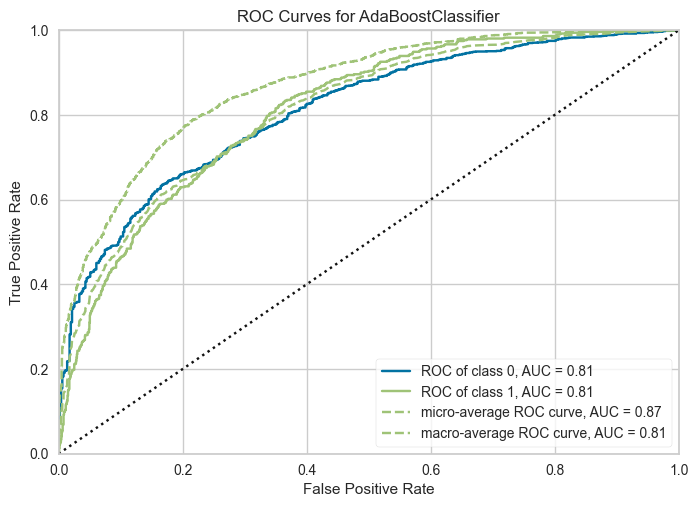

In [24]:
plot_model(best_model, plot="auc")

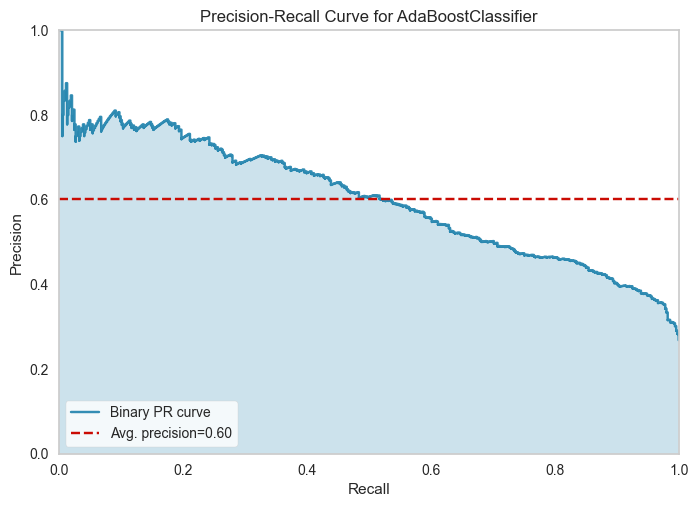

In [25]:
plot_model(best_model, plot="pr")

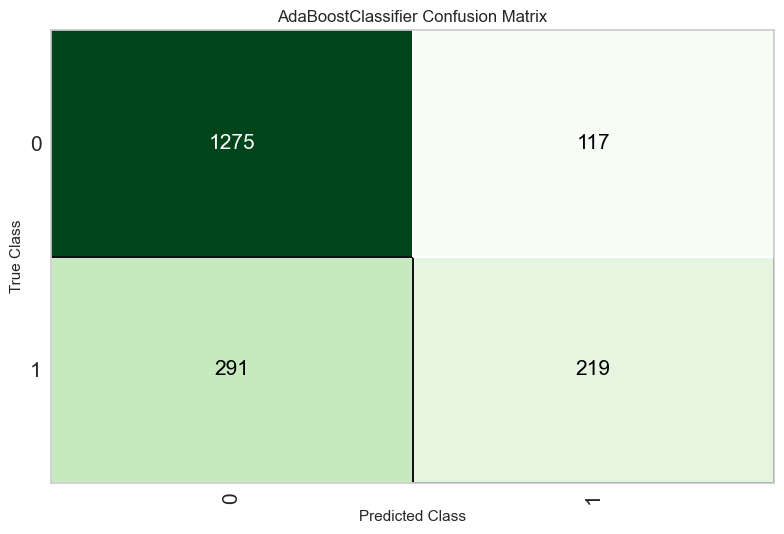

In [26]:
plot_model(best_model, plot="confusion_matrix")

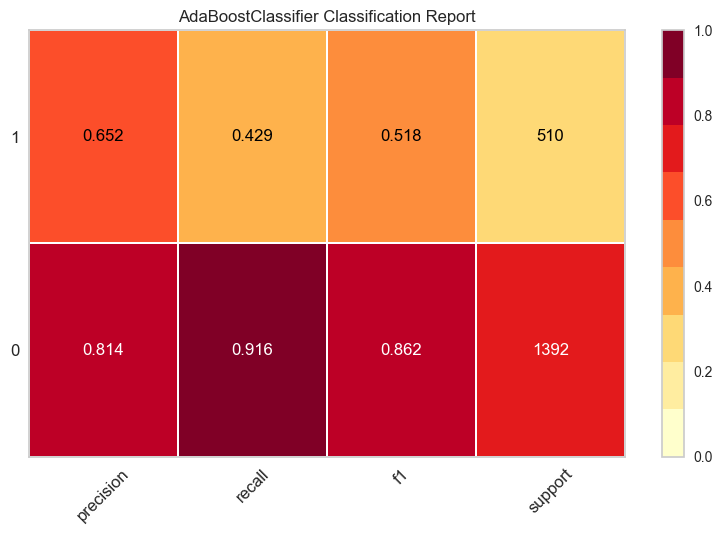

In [27]:
plot_model(best_model, plot="class_report")

In [28]:
# Prediction on Test Data
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7855,0.8108,0.7855,0.7706,0.7697,0.3872,0.4012


In [29]:
final_model = finalize_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8125,0.8441,0.8125,0.7995,0.8015,0.4305,0.4392


 Accuracy  AUC  Recall  Precision  F1 Score
      1.0  1.0     1.0        1.0       1.0


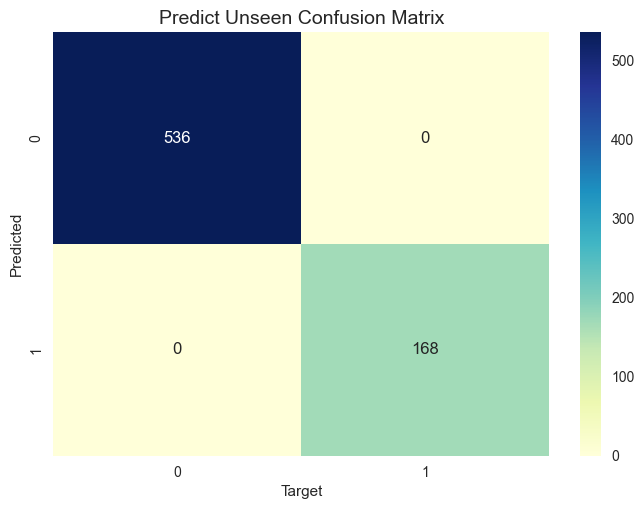

In [ ]:
# Prediction on Unseen Data
predict_unseen = predict_model(final_model, data=data_unseen);
score_unseen = test_score_report(data_unseen, predict_unseen)
print(score_unseen.to_string(index=False))
conf_mat(data_unseen, predict_unseen)

In [33]:
#Save Experiment and Model
#Save Experiment and Model
models_dir = PATH + "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

save_model(final_model, models_dir + os.sep + "modelCCP_" + date.today().strftime("%m-%d-%Y"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SeniorCitizen', 'tenure',
                                              'MonthlyCharges', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty...
                  AdaBoostClassifier(algorithm='SAMME.R',
                                     estimator=LogisticRegression(C=0.139,
                                                                  class_weight